In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import sys
from IPython.core.debugger import set_trace
import os
sys.path.insert(0, os.path.abspath('./week4/exos4/'))
from prologue import *
import matplotlib.pyplot as plt
from time import perf_counter 
from decimal import Decimal
import numpy as np

In [2]:
train_input, train_target, test_input, test_target = \
load_data(one_hot_labels = True, normalize = True, flatten = False)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


## Dimensions exercises

**N x 1 x 28 x 28** conv2d
**N x 32 x 24 x 24** maxpooling
**N x 32 x 8 x 8**conv2d
**N x 64 x 4 x 4**maxpooling
**N x 64 x 2 x 2**

In [75]:
temp1 = train_input[0].view(-1,1,28,28)
temp2 = nn.Conv2d(1,32,kernel_size=5)(temp1)
temp3 = F.max_pool2d(temp2, kernel_size=3, stride=3)
temp4 = nn.Conv2d(32, 64, kernel_size=5)(temp3)
temp5 = F.max_pool2d(temp4, kernel_size=2, stride=2)

for i in [temp1,temp2,temp3,temp4,temp5]:
    print(i.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 24, 24])
torch.Size([1, 32, 8, 8])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 2, 2])


In [146]:
class Net(nn.Module):
    def __init__(self,n_units = 200):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, n_units)
        self.fc2 = nn.Linear(n_units, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

model, criterion = Net(), nn.MSELoss()
eta, mini_batch_size = 1e-1, 100

In [113]:
def train_model(model,train_input,train_target,mini_batch_size,epochs = 25,verbose = False):
    for e in range(0,epochs):
        sum_loss = 0
        for b in range(0,train_input.size(0),mini_batch_size):
            #output = model(train_input[b:b + mini_batch_size])
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
        if verbose:
            print(e, sum_loss)

In [126]:
def compute_nb_errors(model,input,target,mini_batch_size):
    """
    assume the model is already trained
    """
    nb_errors = 0
    pred_lab = torch.argmax(model(input),axis= 1)
    true_lab = torch.argmax(target,axis = 1)
    nb_errors += (pred_lab != true_lab).int().sum()
    return nb_errors.item()

In [127]:
def compute_nb_errors2(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

## Question 2

In [145]:
REP = 5
train_input, train_target, test_input, test_target = \
load_data(one_hot_labels = True, normalize = True, flatten = False)
for i in range(REP):
    mini_batch_size = 100
    model = Net()
    train_model(model, train_input, train_target, mini_batch_size)
    nb_err1 = compute_nb_errors(model,test_input,test_target,mini_batch_size) 
    print("error ratio: {:0.2f} %".format(nb_err1/test_input.size(0) * 100))

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
error ratio: 14.70 %
error ratio: 14.50 %
error ratio: 17.60 %
error ratio: 13.30 %
error ratio: 12.60 %


## Question 3

In [150]:
n_units = [10,50,200,500,1000]
train_input, train_target, test_input, test_target = \
load_data(one_hot_labels = True, normalize = True, flatten = False)
for n_unit in n_units:
    nb_err = 0
    for i in range(REP):
        mini_batch_size = 100
        model = Net(n_unit)
        train_model(model, train_input, train_target, mini_batch_size)
        nb_err += compute_nb_errors(model,test_input,test_target,mini_batch_size)
    nb_err/=REP
    print("N_units: {:0.2f} | error ratio: {:0.2f} %".format(n_unit,nb_err/test_input.size(0) * 100)) 

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
N_units: 10.00 | error ratio: 39.22 %
N_units: 50.00 | error ratio: 15.94 %
N_units: 200.00 | error ratio: 15.16 %
N_units: 500.00 | error ratio: 14.54 %
N_units: 1000.00 | error ratio: 12.78 %


## Question 4

**N x 1 x 28 x 28**conv2d
**N x 32 x 24 x 24**maxpool
**N x 32 x 12 x 12**conv2d
**N x 64 x 10 x 10**maxpool
**N x 64 x 5 x 5**conv2d
**N x 128 x 4 x 4**maxpool
**N x 128 x 2 x 2**

## Classes

In [4]:
class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(cfg[-1][1], num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def EfficientNetB0():
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 2),
           (6,  24, 2, 1),
           (6,  40, 2, 2),
           (6,  80, 3, 2),
           (6, 112, 3, 1),
           (6, 192, 4, 2),
           (6, 320, 1, 2)]
    return EfficientNet(cfg)

In [ ]:
class Block(nn.Module):
    '''expand + depthwise + pointwise + squeeze-excitation'''

    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1,
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_planes, out_planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_planes//16, out_planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out

In [3]:
class Net2(nn.Module):
    def __init__(self,n_hidden = 100,chan = 1):
        super(Net2,self).__init__()
        self.hidden = n_hidden
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(chan,32,kernel_size=3),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.BatchNorm2d(64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(2304,n_hidden),
            nn.Dropout(0.5),
            nn.Linear(n_hidden,10)
            #nn.Softmax2d()
        )
    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x.view(x.size(0),-1))
        return x

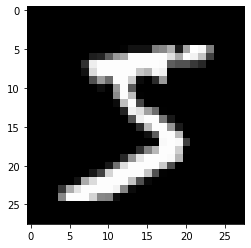

In [4]:
plt.imshow(train_input[0][0],cmap='gray',interpolation='none')

## Execution

In [5]:
train_input, train_target, test_input, test_target = \
load_data(cifar = True,normalize = True, flatten = False)

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [6]:
EPOCHS = 50
batch_size = 100

eta = 0.01

model = Net2(chan=3)
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
for ep in range(EPOCHS):
    print("epoch %i /%i" % (ep+1,EPOCHS))
    sum_loss = 0
    # Train Model
    for i in range(0,train_input.size(0),batch_size):
        targ = train_target.narrow(0,i,batch_size)
        pred = model(train_input.narrow(0,i,batch_size))
        loss = criterion(pred,targ)
        sum_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print ("C-E loss: %.2f" % sum_loss)

epoch 1 /50
C-E loss: 20.33
epoch 2 /50
C-E loss: 13.64
epoch 3 /50
C-E loss: 10.10
epoch 4 /50
C-E loss: 7.84
epoch 5 /50
C-E loss: 6.36
epoch 6 /50
C-E loss: 4.83
epoch 7 /50
C-E loss: 3.66
epoch 8 /50
C-E loss: 2.65
epoch 9 /50
C-E loss: 2.06
epoch 10 /50
C-E loss: 1.62
epoch 11 /50
C-E loss: 1.27
epoch 12 /50
C-E loss: 0.94
epoch 13 /50
C-E loss: 0.87
epoch 14 /50


KeyboardInterrupt: 

In [441]:
def get_accuracy(input,targets):
    tot_loss = 0
    nb_correct = 0
    for i in range(0,input.size(0),mini_batch_size):
        pred = model(input.narrow(0,i,mini_batch_size))
        pred = torch.argmax(pred,axis = 1)
        target = targets.narrow(0,i,mini_batch_size)
        nb_correct += (pred == target).int().sum().item()
    print("accuracy: %.2f" % (nb_correct /test_input.size(0)) )

In [472]:
get_accuracy(train_input,train_target)

get_accuracy(test_input,test_target)

## Vizualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


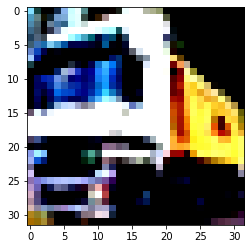

In [62]:
temp = train_input[1]
res = model.conv_block1[0](temp.unsqueeze(0)).squeeze()
plt.imshow(temp.permute(1, 2, 0))

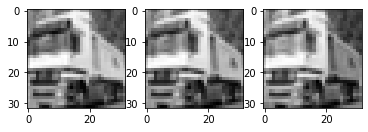

In [66]:
fig,ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(temp[i],cmap='gray',interpolation='none')

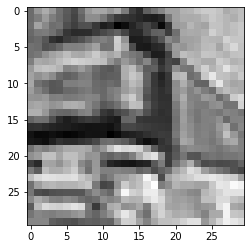

In [72]:
plt.imshow(res.detach()[24],cmap='gray',interpolation='none')

## Unexplained C-E loss

In [205]:
targ.shape

torch.Size([100, 10])

In [357]:
a = torch.Tensor([0]).long()
b = torch.Tensor([[0.4,0.5,0.1]]).requires_grad_()
loss(b,a)

tensor(1.0459, grad_fn=<NllLossBackward>)

In [358]:
np.log(np.exp(0.4)/(np.exp(0.4) + np.exp(0.5)+ np.exp(0.1)))

-1.0459106833418141

In [374]:
a = torch.Tensor([[1,0,0]])
b = torch.Tensor([[0.4,0.5,0.1]]).requires_grad_()
torch.nn.functional.binary_cross_entropy(b, a)

tensor(0.5716, grad_fn=<BinaryCrossEntropyBackward>)

In [354]:
np.log(0.5)

-0.6931471805599453